In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.stats import ttest_1samp, kendalltau, ttest_ind, ranksums
from sklearn.neighbors import NearestNeighbors


In [2]:
df = pd.read_excel('Violence_Homicide.xlsx',sheet_name='Data')
df.loc[df.GeoAreaName=='Philippines']
df = df[['GeoAreaName', 'Sex', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018']]
df = pd.melt(df, id_vars=['GeoAreaName','Sex'], value_vars = df.columns[2:])
df = df[['GeoAreaName','variable','Sex','value']]
df.columns = ['country','year','sex','value']

df2 = pd.read_csv('Violence_Homicide_2.csv')
df2.columns = [(str(x)+str(y)).strip().replace('nan','') for (x,y) in zip(df2.loc[0],df2.loc[1])]
df2 = df2.drop([0,1],axis=0)
df2 = pd.melt(df2, id_vars=['Country'], value_vars=df2.columns[1:])
df2['year'] = [i[:5] for i in df2.variable]
df2['type'] = [i[5:] for i in df2.variable]
df2 = df2[['Country','year','type','value']]
df2.columns = ['country','year','sex','value']

df = df.append(df2)
df['sex'] = df.sex.str.upper()
del df2

In [3]:
df = df.loc[df.value.notnull()].sort_values(by='year')
df = df.reset_index(drop=True)
df['year'] = df['year'].astype(int)
df['value'] = df['value'].astype(float)
df

,country,year,sex,value
0,Albania,2000,FEMALE,0.84102
1,Romania,2000,FEMALE,1.23810
2,Republic of Moldova,2000,MALE,15.54676
3,Republic of Moldova,2000,FEMALE,5.48922
4,Puerto Rico,2000,MALE,37.42445
...,...,...,...,...
7221,Bhutan,2018,FEMALE,0.56404
7222,Bhutan,2018,MALE,1.75083
7223,Bosnia and Herzegovina,2018,FEMALE,0.47182
7224,Azerbaijan,2018,FEMALE,1.32363


#### Insight
The number of homicides had previously decreased, but <b>rose again towards 2015/2016</b>

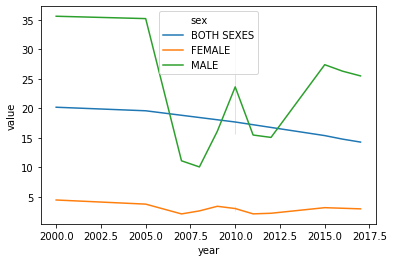

In [4]:
sns.lineplot(df[df.country=='Philippines']['year'],
             df[df.country=='Philippines']['value'],
             hue=df[df.country=='Philippines']['sex'])

In [5]:
df = pd.pivot_table(df, values='value', index=['country', 'year'],
                    columns=['sex']).reset_index()
df['diff'] = df['MALE']-df['FEMALE']

In [6]:
df_ph = df.loc[df.country=='Philippines']
df_ph

sex,country,year,BOTH SEXES,FEMALE,MALE,diff
1785,Philippines,2000,20.2,4.500000,35.60000,31.100000
1786,Philippines,2005,19.6,3.800000,35.20000,31.400000
1787,Philippines,2007,NaN,2.143650,11.13408,8.990430
1788,Philippines,2008,NaN,2.653040,10.09546,7.442420
1789,Philippines,2009,NaN,3.435550,16.12582,12.690270
1790,Philippines,2010,17.7,3.052265,23.64014,20.587875
1791,Philippines,2011,NaN,2.151130,15.49659,13.345460
1792,Philippines,2012,NaN,2.254350,15.09240,12.838050
1793,Philippines,2015,15.4,3.200000,27.40000,24.200000
1794,Philippines,2016,14.8,3.100000,26.30000,23.200000


#### Insight
* Rates of male and female homicide are not changing throughout the years
* Male rates of homicide are <b>significantly higher than females</b>

In [7]:
t_T, p_T = ranksums(df_ph['FEMALE'],df_ph['MALE'])
t_F, p_F = kendalltau(df_ph['year'],df_ph['FEMALE'])
t_M, p_M = kendalltau(df_ph['year'],df_ph['MALE'])

print(f"Male Homicide Trend\n Slope: {t_M}, p-val: {p_M}")
print(f"Female Homicide Trend\n Slope: {t_F}, p-val: {p_F}")
print(f"Test for difference in means: p-val: {p_T}")

Male Homicide Trend
 Slope: -0.018181818181818184, p-val: 1.0
Female Homicide Trend
 Slope: -0.2, p-val: 0.4453821448613115
Test for difference in means: p-val: 7.105263288600155e-05


In [8]:
sea = ['Viet Nam','Malaysia','Indonesia','Thailand','Cambodia','Philippines']

#### Insight
* The Philippines has the highest rates of homicide for both males and females in Southeast Asia

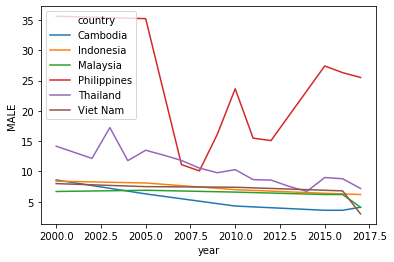

In [9]:
sns.lineplot(df.loc[df.country.isin(sea)]['year'],
             df.loc[df.country.isin(sea)]['MALE'],
             hue=df.loc[df.country.isin(sea)]['country'])

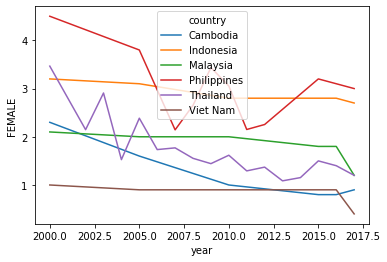

In [10]:
sns.lineplot(df.loc[df.country.isin(sea)]['year'],
             df.loc[df.country.isin(sea)]['FEMALE'],
             hue=df.loc[df.country.isin(sea)]['country'])

#### Insight
* In fact, the Philippines is <b>most similar to countries like Nicaragua, Panama, Paraguay, and DR Congo</b> in terms of homicide rate for both males and females

In [11]:
df_ave = df.groupby('country').agg({'FEMALE':np.mean,'MALE':np.mean})
df_ave = df_ave.reset_index()

In [12]:
df_ave.loc[df_ave.country.isin(sea), 'color'] = 'SEA'
df_ave.loc[df_ave.country=='Philippines', 'color'] = 'PH'
df_ave.loc[df_ave.color.isnull(), 'color'] = 'Other'

[(0, 8)]

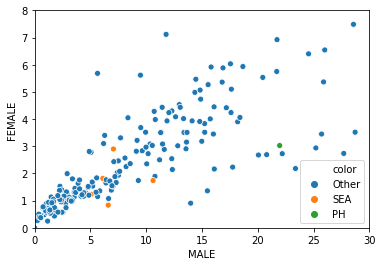

In [13]:
a_plot = sns.scatterplot(df_ave['MALE'],
                df_ave['FEMALE'],
                hue=df_ave['color'])
a_plot.set(xlim=(0, 30))
a_plot.set(ylim=(0, 8))

In [14]:
df_ave['FEMALE'] = df_ave.FEMALE.fillna(np.nanmedian(df_ave.FEMALE))
df_ave['MALE'] = df_ave.MALE.fillna(np.nanmedian(df_ave.MALE))

In [15]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(df_ave[['FEMALE','MALE']])
distances, indices = nbrs.kneighbors(df_ave[['FEMALE','MALE']])

In [16]:
df_ave.loc[indices[157]]

,country,FEMALE,MALE,color
157,Philippines,3.026362,21.962226,PH
144,Nicaragua,2.726676,22.191117,Other
184,Small island developing States (SIDS),2.690551,20.796190,Other
153,Panama,2.180801,23.377189,Other
155,Paraguay,2.677991,20.061391,Other
56,Democratic Republic of the Congo,5.750000,21.700000,Other
180,Sierra Leone,5.533333,20.450000,Other
62,Ecuador,2.937893,25.203734,Other
208,Uganda,4.059306,18.401695,Other
26,Botswana,3.450000,25.716667,Other
